In [1]:
knitr::opts_chunk$set(fig.align='center')

HeiDI is <a href="https://psycnet.apa.org/record/2020-24823-001" target="blank">a recent model</a> developed by Rob Honey, Dom Dwyer and their student, Adela Iliescu. The model has a fairly simple (R-W) architecture, however, it has forward and backward associations. In addition, it has an "expression" side to it, as it includes combination rules that allow for transfer along stimulus chains. So, the model gets computationally expensive fairly quickly.

In [2]:
require(tidyverse)
require(patchwork)
require(truncnorm) #For sampling
theme_set(theme_bw())

Loading required package: tidyverse

Warning message:
"package 'tidyverse' was built under R version 4.2.3"
Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
Warning message:
"package 'lubridate' was built under R version 4.2.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ─

# Simple excitatory acquisition

To get up to speed, here's an implementation of the acquisition of a single excitatory association between two stimuli (A and B). First, stipulate the trials. Here let's assume that

$$p(A|B) = p(B|A) = .8$$
$$p(A|\overline{B}) = .2$$
$$p(B|\overline{A}) = .3$$

In [3]:
trialmat <- rbind(c(1, 1),
                  c(1, 0),
                  c(0, 1))
rownames(trialmat) <- c('AB', 'A', 'B')
#And sample a training regime
set.seed(1) #reproducibility
trials <- sample(1:3, size = 40, replace = T, prob = c(.8, .2, .3))
head(trialmat[trials, ])


AB,1,1
AB,1,1
AB,1,1
A,1,0
AB,1,1
A,1,0


We now have to come up with parameters for the stimuli. Saliency parameters ($\alpha$ and $\beta$ for CSs and USs, respectively) are bounded in the model. We can express them as being sampled from the following distributions.

$$\alpha \sim Normal(\mu, \sigma)_{[0, +\infty]}$$
$$\beta \sim Normal(\mu, \sigma)_{[-\infty, 1]}$$

Where the brackets indicate a truncation along that range, $\mu$ is the mean of each parameter, and $\sigma$ its standard deviation (notation simplified for convenience). I am not very clear on the truncation range for $\beta$, but not an issue. Sampling statements like this would allow us to estimate population and group parameters. Let's sample the parameters assuming that both stimuli are CSs.

In [4]:
sals <- rtruncnorm(n = 2, mean = c(.3, .5), sd = c(.1, .1), a = 0, b = Inf)
sals


[1] 0.3918977 0.5782136

Finally, the model also has a scaling constant that transforms these saliency parameters to asymptotic values (your typical $\lambda$). For now, let's make them the inverse of the saliencies.

In [5]:
cons <- 1/sals

And let's create a function that "initiates a model". Important for data-keeping purposes.

In [6]:
# A function that initializes the model weights
genWeights <- function(stims, default_val = 0){
  mat = matrix(default_val, ncol = length(stims), nrow = length(stims)) #perhaps a diagonal with 1s? Would accommodate self-association but increases model complexity.
  rownames(mat) = stims
  colnames(mat) = stims
  return(mat)
}
w <- genWeights(stims = c("A", "B")) #example
w

,A,B
A,0,0
B,0,0


With all of that we can actually start learning. The default learning equation uses a pooled error term for the predicted stimuli. The activation of the representation of stimulus $k$, as predicted by $j$ is defined as:

$$v_k = x_jw_{j,k}$$
where $v_k$ is activation of stimulus $k$, $x_j$ denotes the activation of stimulus $j$ (simplified for now to be 0 or 1), and $w_{j,k}$ is the associative strength of the association $j→k$. To pool all stimuli on a trial, this expression reduces to: $v = xW$, where $W$ is a matrix containing all associative strengths.

Each stimulus association is updated via:

$$\Delta w_{k,j} = \alpha_jx_j(c_k\alpha_k-v_k)$$
Where $\Delta w_{k,j}$ is the change in the kth, jth entry in the weight matrix $W$, $\alpha_j$ is the salience of the predictor, $\alpha_k$ is the salience of the stimulus being predicted, and $c_k$ is a constant mapping the saliency of predicted stimulus $k$ to its asymptote.

The full matrix can be calculated in one go via:

$$\Delta W = (\alpha \odot x ) (c \odot \alpha - v)$$
Where $\odot$ denotes pointwise multiplication. However, if we do this, we must remember to zero out the diagonal of $\Delta W$, because the model does not consider auto-association. (I wonder if they have explored this?)

Here's the implementation of the function to train the model.

In [7]:
trainHEIDI <- function(sals, cons, w, trials, trialmat){
  dat = array(NA, dim = c(length(trials), dim(w)), 
              dimnames = list(NULL, rownames(w), rownames(w)))
  for (t in 1:length(trials)){
    x = trialmat[trials[t], ]
    v = x%*%w #forward activation
    error = (cons*sals*x)-v
    #calculate deltas
    deltaw = (sals*x)%*%error
    #make diagonal 0
    diag(deltaw) = 0
    #learn
    w = w+deltaw
    #save data
    dat[t, , ] = w
  }
  return(dat)
}


With that, we can train the model and visualize the acquisition of each association.

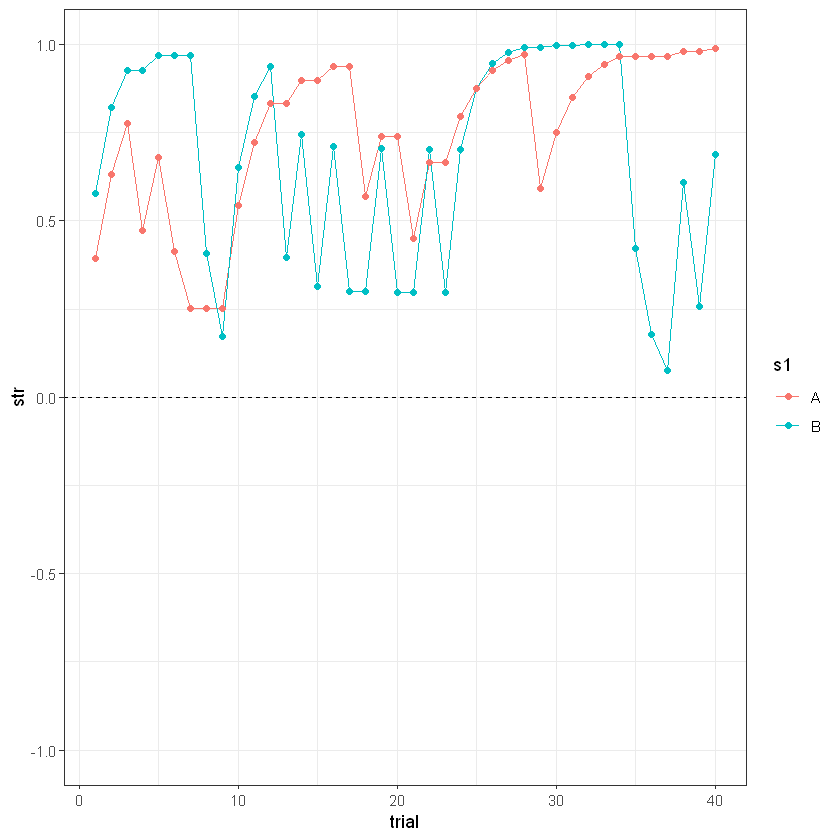

In [8]:
data <- trainHEIDI(sals, cons, w = genWeights(c('A', 'B')), trials, trialmat)
#The data is (t, s, s); t = trials, s = number of stimuli; it's the weight matrix across trials.
#A simple function to parse the data
parseW <- function(dat, trialmat, trials, stimnames = NA){
  #dat is the array of weights returned by the trainHEIDI function
  tname <- rownames(trialmat)
  dat = enframe(apply(dat, 1, function(x) as.data.frame(as.table(x))), name = 'trial') %>% 
    mutate(trialtype = tname[trials]) %>% 
    unnest(value) %>% filter(Var1 != Var2) %>% rename(s1 = Var1, s2 = Var2, str = Freq)
  return(dat)
}

#visualizing the evolution of the A>B and B>A associations
datadf <- parseW(data, trialmat, trials)
datadf %>% ggplot(aes(x = trial, y = str, colour = s1)) + 
  geom_line() + geom_point() + 
  geom_hline(yintercept = 0, linetype = 'dashed') + 
  coord_cartesian(ylim = c(-1, 1)) 


Note the big swings. Those trials carried a lot of error. Let's try running the model many times to get a better idea of the learning functions.

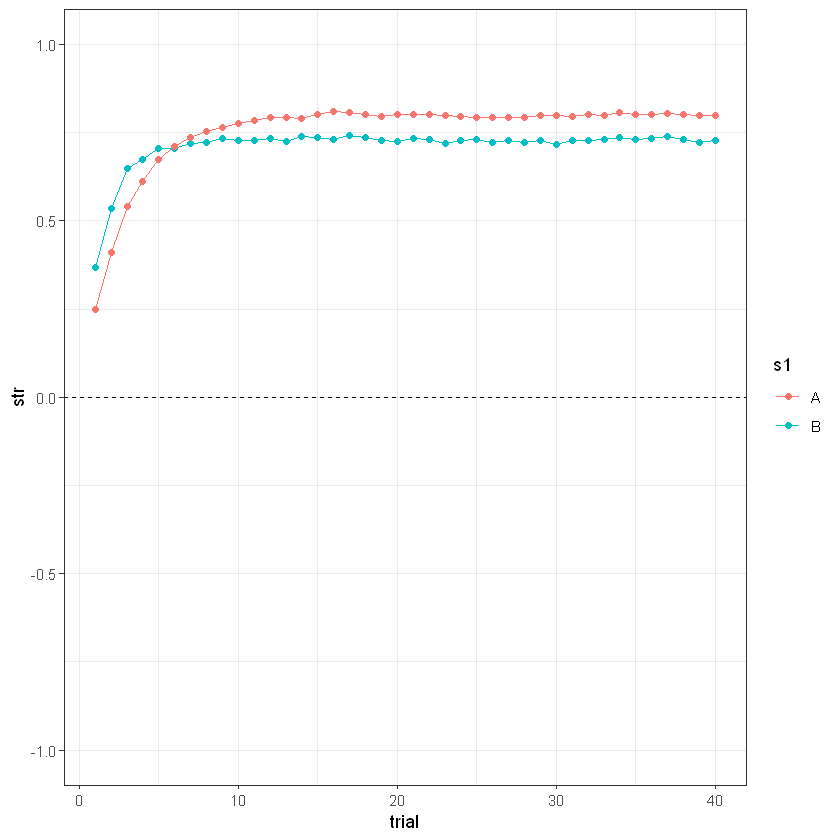

In [9]:
iterations <- 1000
trialF <- function() sample(1:3, size = 40, replace = T, prob = c(.8, .2, .3))
repdata <- replicate(iterations, trainHEIDI(sals, cons, w = genWeights(c('A', 'B')), trialF(), trialmat))
repdata <- apply(repdata, c(1, 2, 3), 'mean') #averaging over dimensions

#doesn't make much sense to use the trials argument in parseW, but still
parseW(repdata, trialmat, trials) %>% ggplot(aes(x = trial, y = str, colour = s1)) + 
  geom_line() + geom_point() + 
  geom_hline(yintercept = 0, linetype = 'dashed') + 
  coord_cartesian(ylim = c(-1, 1)) 


Easy enough.

# Simple Pavlovian Inhibition

Pick up some velocity by simulating Pavlovian Inhibition (A+/AB-). Create the trials:

In [10]:
#Note that the third column is the US column.
trialmat <- rbind(c(1, 0, 1),
                  c(1, 1, 0))
rownames(trialmat) <- c('A+', 'AB-')
#And sample a training regime
set.seed(1) #reproducibility
trialF <- function() sample(1:2, size = 40, replace = T, prob = c(.5, .5))
head(trialmat[trialF(), ])


AB-,1,1,0
AB-,1,1,0
A+,1,0,1
A+,1,0,1
AB-,1,1,0
A+,1,0,1


We can reuse the previous code to train the model. And create a convenience function that replicates the training.

In [11]:
sals <- c(.3, .3, .6)
cons <- 1/sals

replicateHEIDI <- function(iters, fcall){
  return(apply(replicate(iters, fcall()), c(1, 2, 3), 'mean'))
}
pav_in_dat <- replicateHEIDI(100, function() trainHEIDI(sals, cons, w = genWeights(c('A', 'B', 'US')), trialF(), trialmat))
pav_in_dat <- parseW(pav_in_dat, trialmat, trialF())
head(pav_in_dat)

trial,s1,s2,str,trialtype
<int>,<fct>,<fct>,<dbl>,<chr>
1,B,A,0.162,AB-
1,US,A,0.276,AB-
1,A,B,0.162,AB-
1,US,B,0.000,AB-
1,A,US,0.138,AB-
1,B,US,0.000,AB-


Now we can plot stuff we really care about. For example, the activation of the US representation as a function of training for each trial type, or as a function of each stimulus.

`summarise()` has grouped output by 'trial'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'trial'. You can override using the
`.groups` argument.


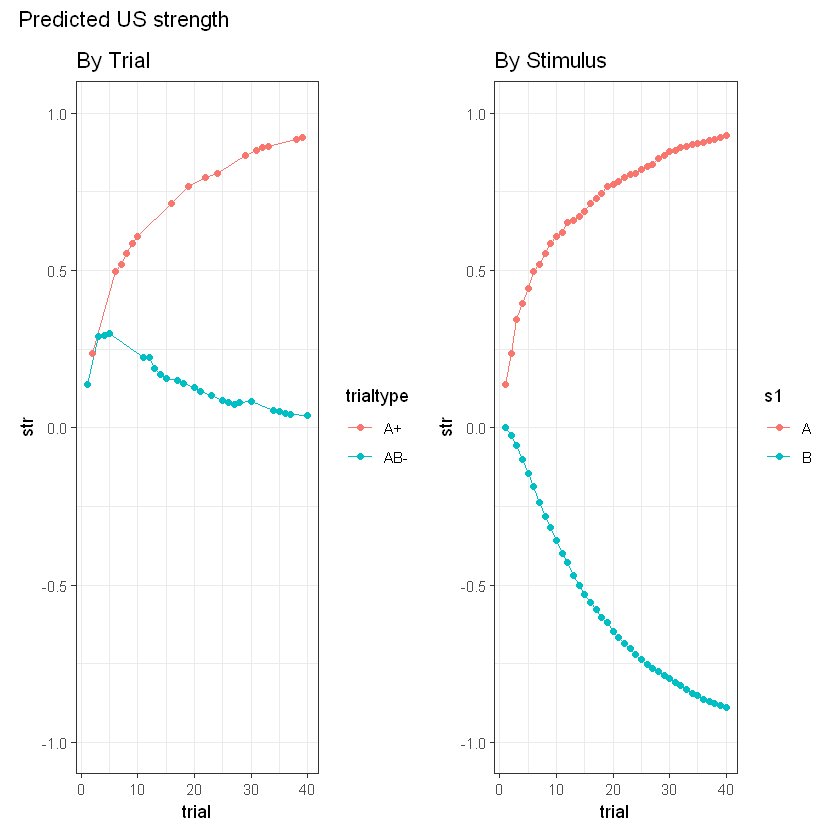

In [12]:
#C is the US
US_by_trial <- pav_in_dat %>% filter(s2 == 'US') %>% 
  rowwise() %>% filter(grepl(s1, trialtype)) %>% group_by(trial, trialtype) %>%
  summarise(str = sum(str)) %>% ggplot(aes(x = trial, y = str, colour = trialtype)) + 
  geom_line() + geom_point() + coord_cartesian(ylim = c(-1, 1)) + labs(title = 'By Trial')
US_by_stim <- pav_in_dat %>% filter(s2 == 'US') %>%
  group_by(trial, s1) %>% 
  summarise(str = sum(str)) %>% ggplot(aes(x = trial, y = str, colour = s1)) + 
  geom_line() + geom_point() + coord_cartesian(ylim = c(-1, 1)) + labs(title = 'By Stimulus')
US_by_trial + US_by_stim + plot_annotation(title = 'Predicted US strength')



A neat property of the model is that it assumes that all the stimuli associate with each other. This includes "backward" US-CS associations. We can visualize those, too. Here, let's focus on A as predicted by each trial type and by each stimulus (they should be the same).

`summarise()` has grouped output by 'trial'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'trial'. You can override using the
`.groups` argument.


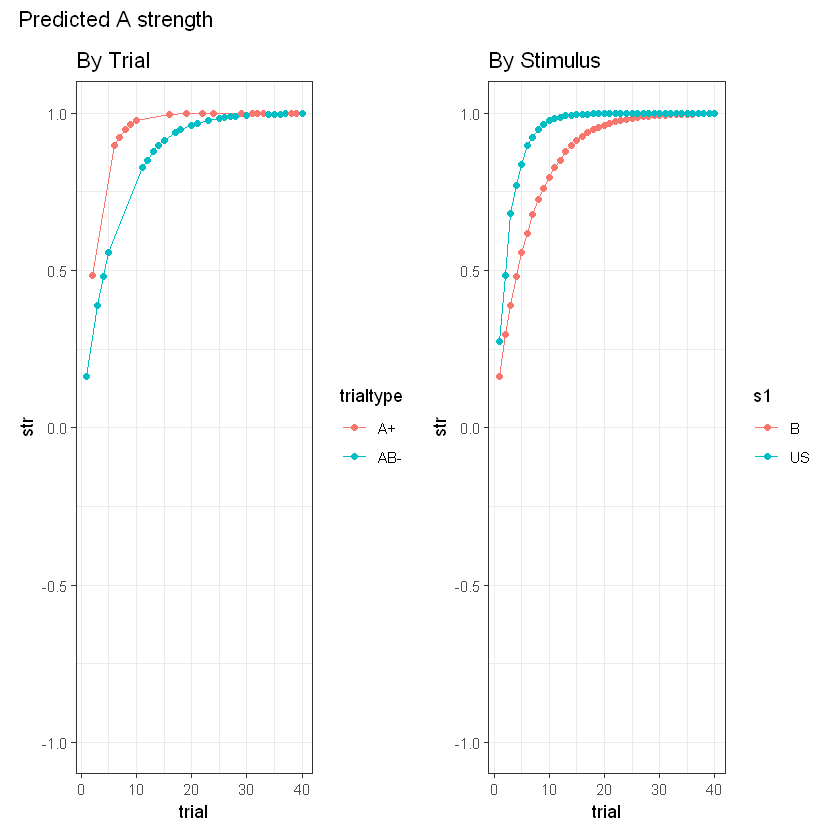

In [13]:
A_by_trial <- pav_in_dat %>% filter(s2 == 'A') %>% 
  rowwise() %>% filter((s1 == 'B' & trialtype == 'AB-') | (s1 == 'US' & trialtype == 'A+')) %>% 
  group_by(trial, trialtype) %>%
  summarise(str = sum(str)) %>% ggplot(aes(x = trial, y = str, colour = trialtype)) + 
  geom_line() + geom_point() + coord_cartesian(ylim = c(-1, 1)) + labs(title = 'By Trial')
A_by_stim <- pav_in_dat %>% filter(s2 == 'A') %>%
  group_by(trial, s1) %>% 
  summarise(str = sum(str)) %>%
  ggplot(aes(x = trial, y = str, colour = s1)) + 
  geom_line() + geom_point() + coord_cartesian(ylim = c(-1, 1)) + labs(title = 'By Stimulus')
A_by_trial + A_by_stim + plot_annotation(title = 'Predicted A strength')

Note the lack of competition between B and the US; they never appear together. Note also how the US develops strength faster than B; the saliency of the US is larger than that of B.

# Relative Validity

One of the classic findings in Pavlovian conditioning stipulates that the response to $A$ is weaker if trained in an $AB+/AC-$ (true) discrimination than if trained in a $AB\pm/AC\pm$ (pseudo) discrimination.

Create the trials and set the relevant parameters.

In [14]:
set.seed(1) #reproducibility
#Note that the third column is now the C column. Fourth is the US.
truemat <- rbind(c(1, 1, 0, 1),
                  c(1, 0, 1, 0))
rownames(truemat) <- c('AB+', 'AC-')
truetrialsF <- function() sample(1:2, size = 40, replace = T)
head(truemat[truetrialsF(), ])

pseudomat <- rbind(c(1, 1, 0, 1),
                   c(1, 1, 0, 0),
                   c(1, 0, 1, 1),
                   c(1, 0, 1, 0))
rownames(pseudomat) <- c('AB+', 'AB-', 'AC+', 'AC-')
pseudotrialsF <- function() sample(1:4, size = 40, replace = T)
head(pseudomat[pseudotrialsF(), ])

#And the parameters
sals <- c(.3, .3, .3, .6)
cons <- 1/sals


AB+,1,1,0,1
AC-,1,0,1,0
AB+,1,1,0,1
AB+,1,1,0,1
AC-,1,0,1,0
AB+,1,1,0,1


AB-,1,1,0,0
AB-,1,1,0,0
AC+,1,0,1,1
AC-,1,0,1,0
AC-,1,0,1,0
AC-,1,0,1,0


Train the models, and put them together.

In [15]:
truemod <- replicateHEIDI(1000, function(){
  trainHEIDI(sals, cons, w = genWeights(c('A', 'B', 'C', 'US')), truetrialsF(), truemat)
  }
)
pseudomod <- replicateHEIDI(1000, function(){ 
  trainHEIDI(sals, cons, w = genWeights(c('A', 'B', 'C', 'US')),pseudotrialsF(), pseudomat)
  }
)
truedat <- parseW(truemod, truetrialsF(), truemat)
pseudodat <- parseW(pseudomod, pseudotrialsF(), pseudomat)

truedat$cond <- 'true'
pseudodat$cond <- 'pseudo'
fulldat <- rbind(truedat, pseudodat)
fulldat$cond <- factor(fulldat$cond, levels = c('true', 'pseudo'))

Now we can plot the associative strength of $A$. Note that Honey et al. also raise an important point: in HeiDI, the relative validity effect depends on the associations that $A$ forms with $B$ and $C$.

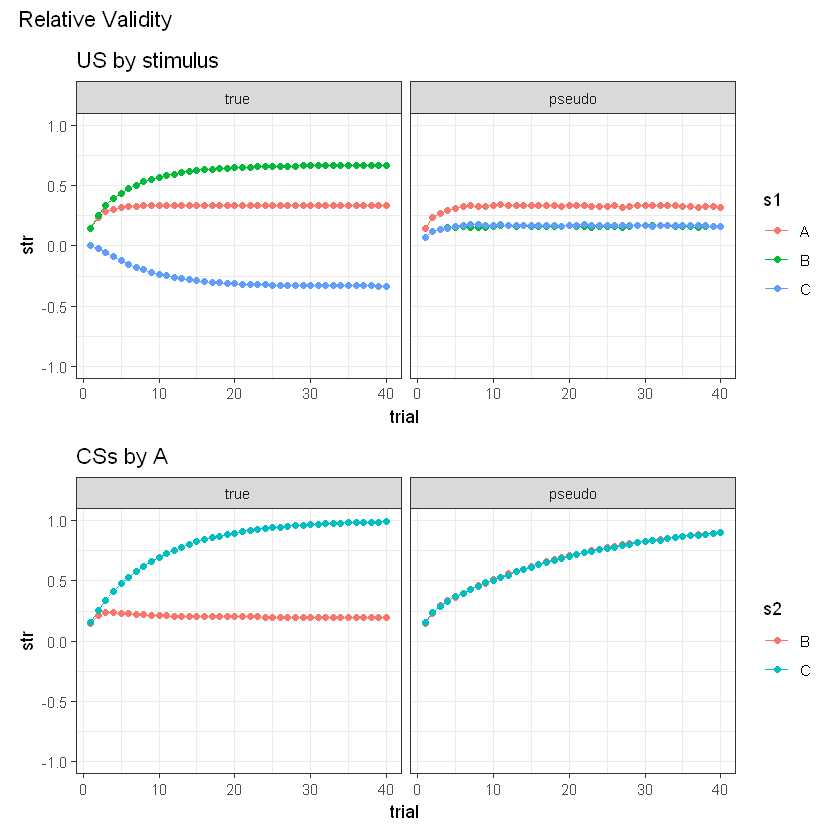

In [16]:
#D is the US
US_plot <- fulldat %>% filter(s2 == 'US') %>% 
  ggplot(aes(x = trial, y = str, colour = s1)) + 
  geom_line() + geom_point() + 
  coord_cartesian(ylim = c(-1, 1)) +
  labs(title = 'US by stimulus') + facet_wrap(~cond)
CS_plot <- fulldat %>% filter(s2 %in% c('B', 'C') & s1 == 'A') %>% 
  ggplot(aes(x = trial, y = str, colour = s2)) + 
  geom_line() + geom_point() + 
  coord_cartesian(ylim = c(-1, 1)) +
  labs(title = 'CSs by A') + facet_wrap(~cond)
US_plot / CS_plot + plot_annotation(title = 'Relative Validity')

Note the slightly higher excitatory strength for A (top-right panel).

The reason for why the CS associations with A make a difference is quite neat, although not easy to wrap our heads around. I'll try to unwrap the ideas the authors present here. The authors first call attention to the backward association between the US and A in both conditions. Let's look at it.

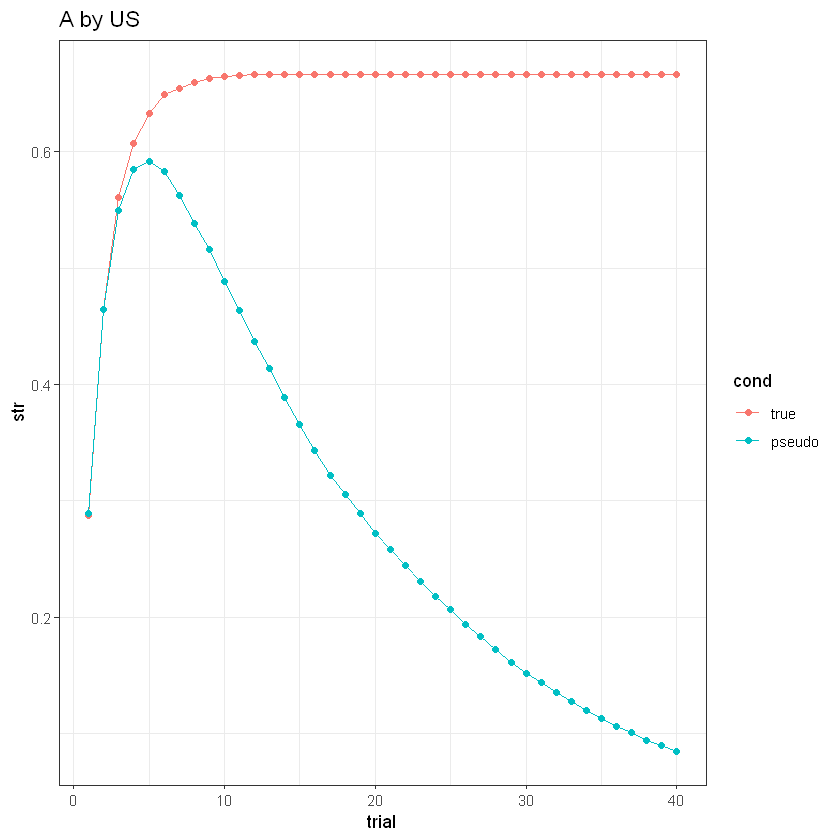

In [17]:
fulldat %>% filter(s1 == 'US' & s2 == 'A') %>% 
  ggplot(aes(x = trial, y = str, colour = cond)) + 
  geom_line() + geom_point() + labs(title = 'A by US')

As expected, the backward association is stronger in the true discrimination group. So, the authors propose that both forward and backward associations "boost" each other. They propose that the combined strength $v_{combined}$ for stimulus $k$ as predicted by stimulus $j$, is:

$$v_{combined(k|j)} = v_{k|j} + \frac{v_{k|j} \times v_{j|k}}{c_k} $$

where $v_{k|j}$ is the strength of the presentation of $k$ given $j$ and $v_{k|j}$ is the strength of the representation of $j$ given $k$. Based on this combination rule, HeiDI predicts stronger responding to A in the true discrimination condition, which is empirically incorrect. Let's look at it.

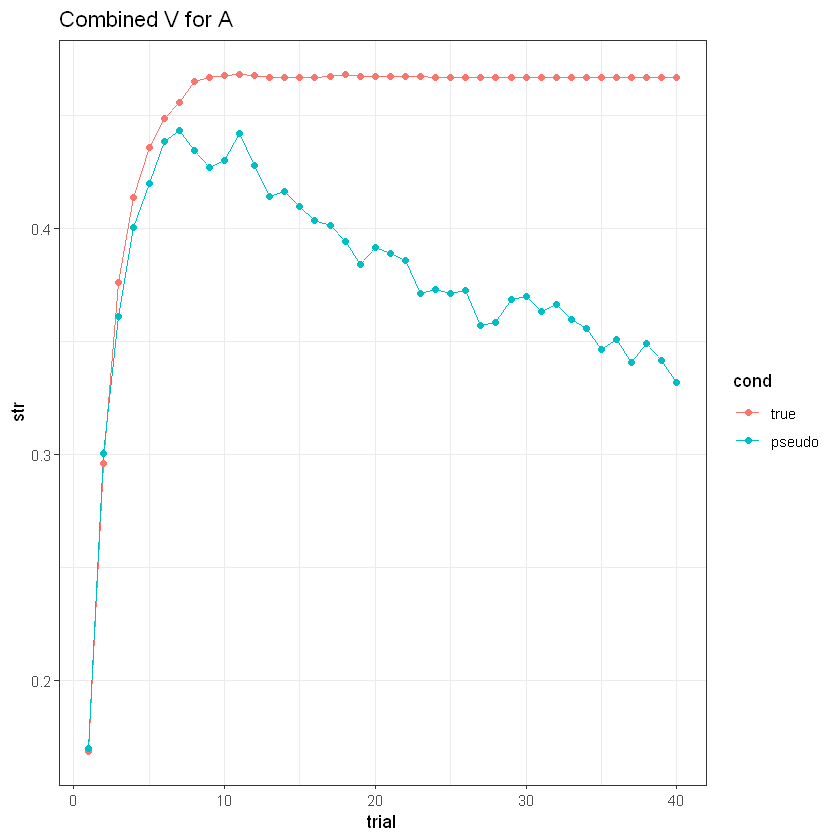

In [18]:
#Create a function to get the combined strength for any two stimuli.
.combV <- function(w, s1, s2, c2){
  #w is a weight matrix, s1 and s2 are stimuli; c2 is the constant for s2
  return(w[s1, s2] + (w[s1, s2]*w[s2, s1]/c2))
}
#The function is meant to be used with the model weights. So let's create a convenience function.
combMod <- function(modw, s1, s2, c2){
  return(apply(modw, 1, function(w) .combV(w, s1, s2, c2)))
}
#combMod(truemod, 'A', 'US', cons[4])
combdat <- tibble(cond = c('true', 'pseudo'), mod = list(truemod, pseudomod)) %>%
  rowwise() %>% mutate(cv = list(enframe(combMod(mod, 'A', 'US', cons[4]), 
                                            name = 'trial', value = 'str'))) %>%
  select(-mod) %>% unnest(cv)
combdat$cond <- factor(combdat$cond, levels = c('true', 'pseudo'))

combdat %>% ggplot(aes(x = trial, y = str, colour = cond)) + 
  geom_line() + geom_point() + labs(title = 'Combined V for A')


Yup, there it is. Look at how unstable the function for the pseudo condition is. The US-A association changes pretty fast throughout training.

The authors solve this problem by positing that A can borrow associative strength from B and C. This means for any two stimuli $j$ and $k$, the representation of $k$ is further activated by the product of the associations that $j$ has with other stimuli, and the associations that those stimuli have with $k$. Formally:

$$ v_{chain(k|j)} = \sum_{i\neq j}{\frac{v_{i|j} \times v_{combined(k|i)}}{c_k}}$$

where $i$ are all the stimuli other than $j$. Let's implement it.

In [19]:
.chainV <- function(w, s1, s2, c2){
  chain_s = setdiff(rownames(w), c(s1, s2)) #larger set is always first
  chain_v = 0
  chain_v = chain_v + sum(sapply(chain_s, function(x) w[s1, x]*.combV(w, x, s2, c2)/c2)) 
  #note the call to .combV above
  return(chain_v)
}
#The function is meant to be used with the model weights. So let's create a convenience function.
chainMod <- function(modw, s1, s2, c2){
  return(apply(modw, 1, function(w) .chainV(w, s1, s2, c2)))
}
#chainMod(truemod, 'A', 'US', cons[4])

There are probably faster ways to write the function above, but let's move on. Let's calculate the the chained associative strength for A in both conditions.

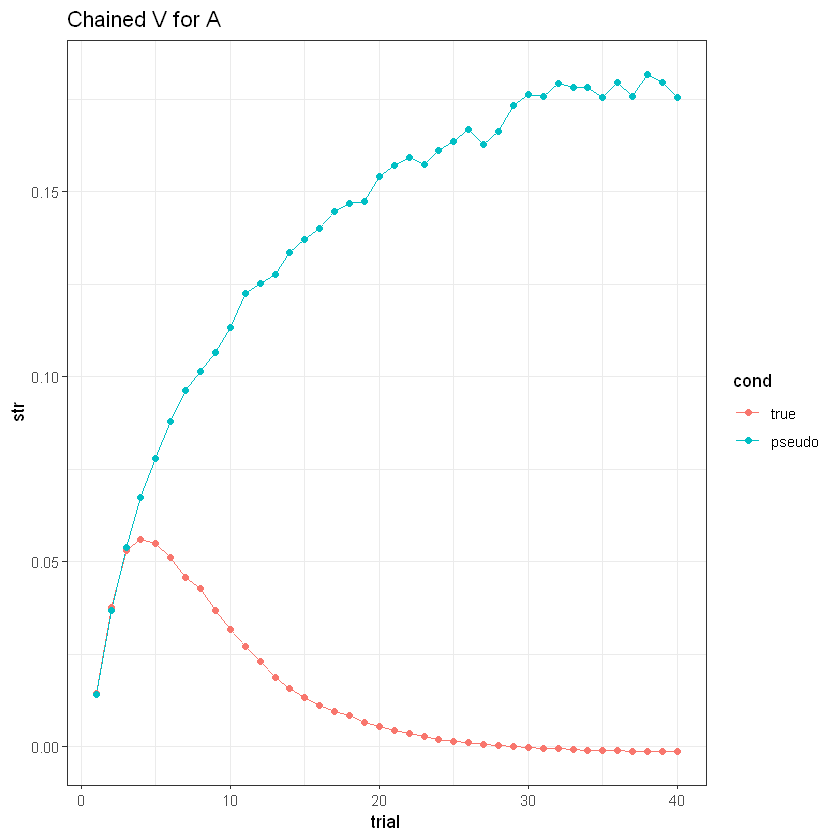

In [20]:

chaindat <- tibble(cond = c('true', 'pseudo'), mod = list(truemod, pseudomod)) %>%
  rowwise() %>% mutate(cv = list(enframe(chainMod(mod, 'A', 'US', cons[4]), 
                                            name = 'trial', value = 'str'))) %>%
  select(-mod) %>% unnest(cv)
chaindat$cond <- factor(combdat$cond, levels = c('true', 'pseudo'))

chaindat %>% ggplot(aes(x = trial, y = str, colour = cond)) + 
  geom_line() + geom_point() + labs(title = 'Chained V for A')


The chained associative strength comes to the rescue. Here's a plot of $v_{total}$ for A (i.e., $v_{combined} + v_{chained}$)

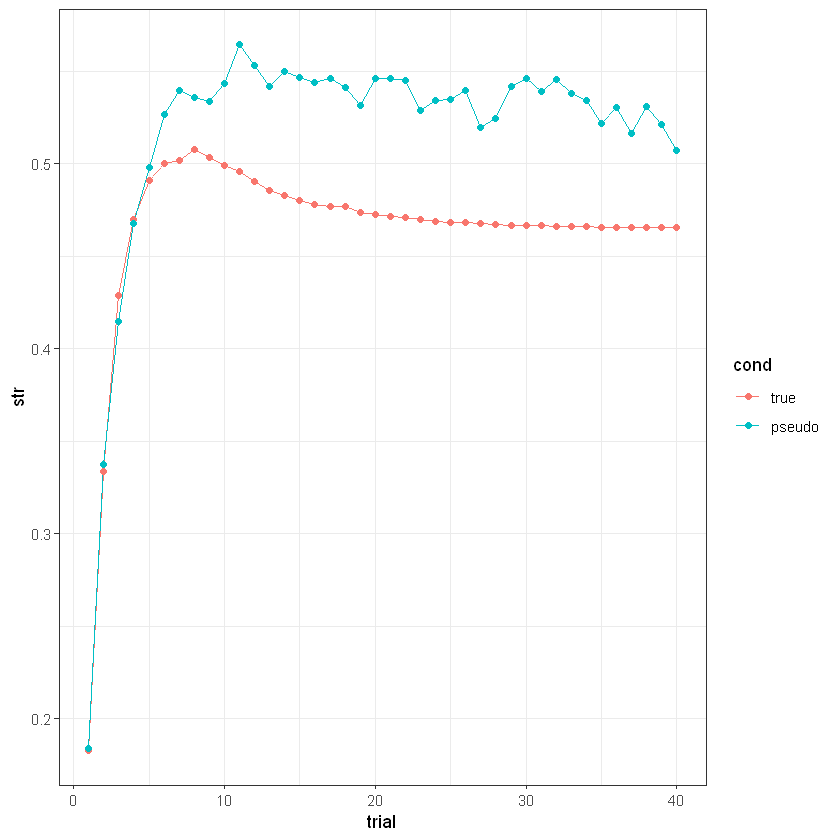

In [21]:
combdat %>% mutate(str = str + chaindat$str) %>% ggplot(aes(x = trial, y = str, colour = cond)) + 
  geom_line() + geom_point() + labs('Total V for A')



And that's how HeiDI explains the relative validity effect (I think?). There are plenty of other points the authors address, but they are all orthogonal to the model architecture. This is good enough for me to build an intuition; now if only I could go to the alps.